### Page Width Adjustment

In [25]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 75%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### Create a Class for Progress Bar

In [26]:
import sys

class ProgressBar():
    
    def __init__(self, max_steps):
        self.max_steps = max_steps
        self.current_step = 0
        self.progress_width = 50

    def update(self, step=None):
        self.current_step = step

        num_pass = int(self.current_step * self.progress_width / self.max_steps) + 1
        num_rest = self.progress_width - num_pass 
        percent = (self.current_step+1) * 100.0 / self.max_steps 
        progress_bar = '[' + '■' * (num_pass-1) + '▶' + '-' * num_rest + ']'
        progress_bar += '%.2f' % percent + '%' 
        if self.current_step < self.max_steps - 1:
            progress_bar += '\r' 
        else:
            progress_bar += '\n' 
        sys.stdout.write(progress_bar) 
        sys.stdout.flush()
        if self.current_step >= self.max_steps:
            self.current_step = 0
            print

# <center>VIX Research

In [27]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

## <center>Import Data

In [28]:
# Bloomberg data 
# Create a dict for data storage 
data = pd.ExcelFile('./data/VIX_data.xlsx')
dfs = {sheet_name: data.parse(sheet_name, header=1, index_col='Dates') 
          for sheet_name in data.sheet_names}

# VIX Futures data (1-month, 2-month)
futures = pd.read_excel('./data/VIX_F.xlsx')
futures.set_index('Dates', inplace=True)
dfs['VIX_Futures'] = futures
dfs['VIX_Futures'].sort_values(by='Dates',inplace=True) ## Ascend Date

In [29]:
#bloomberg data
#data = pd.ExcelFile('./data/VIX_data.xlsx')
#dfs = {sheet_name: data.parse(sheet_name, header=1, index_col='Dates') 
#          for sheet_name in data.sheet_names}
#
#  # VIX Futures data (1-month, 2-month)
#futures = pd.read_excel('./data/vix-funds-models-no-formulas.xls')
#vix_f = futures[['Date', '1st mth', '2nd mth', 'VIX']]  ## add columns from here
#vix_f.set_index('Date', inplace=True)
#dfs['VIX_Futures'] = vix_f
#dfs['VIX Index'] = pd.DataFrame(dfs['VIX_Futures']['VIX'])
#dfs['VIX Index'].rename(columns={'VIX': 'PX_LAST'}, inplace=True)

## <center>Settings

In [30]:
date_from = '2010-12-01'
to_date = '2018-11-27'
for sheet_name in dfs.keys():
    dfs[sheet_name] = dfs[sheet_name].truncate(before=date_from, after=to_date)
    if sheet_name != 'VIX_Futures':
        if sheet_name != 'SPVXSPI Index':
            dfs[sheet_name] = pd.merge(dfs['VIX_Futures'], dfs[sheet_name], on='Dates', how='inner')[['PX_OPEN', 'PX_LOW', 'PX_HIGH', 'PX_LAST', 'PX_VOLUME']]
        else:
            dfs[sheet_name] = pd.merge(dfs['VIX_Futures'], dfs[sheet_name], on='Dates', how='inner')[['PX_LAST']]
            
        dfs[sheet_name]['Return'] = dfs[sheet_name]['PX_LAST'].pct_change(periods=1).dropna()

In [31]:
dfs.keys()

dict_keys(['SPX Index', 'SPY US Equity', 'IVOP US Equity', 'SVXY US Equity', 'XIV US Equity', 'XXV US Equity', 'ZIV US Equity', 'VXX US Equity', 'TVIX US Equity', 'UVXY US Equity', 'VXZ US Equity', 'VIXY US Equity', 'VIIX US Equity', 'SPVXSP Index', 'SPVIX2ME Index', 'SPVIX3ME Index', 'SPVIX4ME Index', 'SPVXMP Index', 'SPVIX6ME Index', 'SH US Equity', 'SPVXSPI Index', 'VIX_Futures'])

### Linear Regression for a Simple Hedge Ratio

In [32]:
import statsmodels.api as sm

def simple_ols(y,X) : 
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) 
    print(model.summary())

In [33]:
simple_ols( dfs['SPY US Equity']['Return'][1:],dfs['VXZ US Equity']['Return'][1:] )
# Delete first row to avoid N/A

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     3673.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:53:26   Log-Likelihood:                 7845.8
No. Observations:                2053   AIC:                        -1.569e+04
Df Residuals:                    2051   BIC:                        -1.568e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.56e-05      0.000      0.816      0.4

### Tickers & Options setup

In [34]:
capital = 200000
prop = 0.36 # VIX proportion
criterion = 200000
trading_days = len(dfs['SPX Index'])
ticker = ['VXZ US Equity', 'SPY US Equity']
date_index = dfs['SPX Index'].index

## <center>Constant Rebalance Date

In [35]:
def rebalance_strategy(rebalance_day):
    port_value = pd.DataFrame(np.zeros((trading_days, 2)), columns=ticker)

    for i in range(trading_days):

        if i == 0:
            port_value[ticker[0]][i] = capital * prop
            port_value[ticker[1]][i] = capital * (1 - prop)

        else:
            port_value[ticker[0]][i] = port_value[ticker[0]][i-1] * (1 + dfs[ticker[0]]['Return'][i])
            port_value[ticker[1]][i] = port_value[ticker[1]][i-1] * (1 + dfs[ticker[1]]['Return'][i])

        # Rebalance
        if ((i+1) % rebalance_day) == 0:
            total = port_value[ticker[0]][i] + port_value[ticker[1]][i]
            port_value[ticker[0]][i] = total * prop
            port_value[ticker[1]][i] = total * (1 - prop)
        else:
            continue
    
    port_value.index = date_index
    return port_value[:]

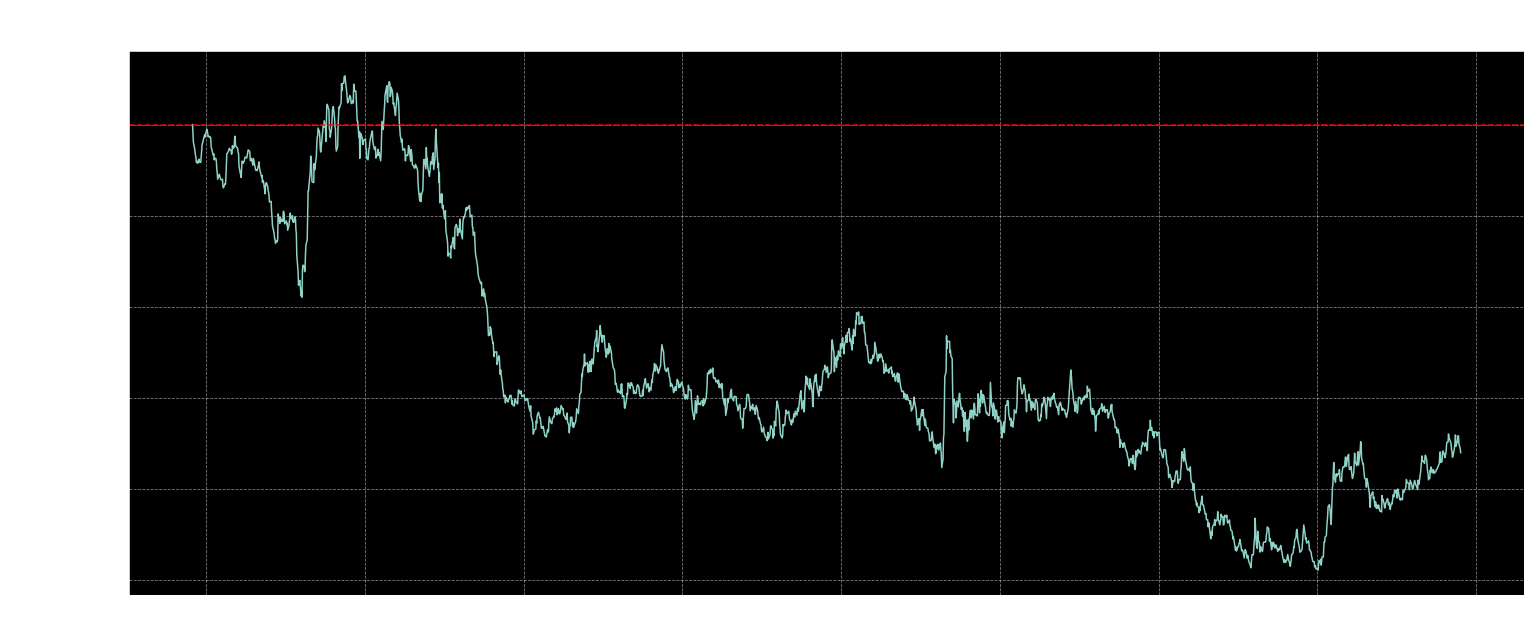

In [36]:
df = rebalance_strategy(90)
df['Total'] = df[ticker[0]] + df[ticker[1]]
plt.figure(figsize=(25,10))
plt.plot(df['Total'])
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)
plt.title('Asset Value',fontsize=50)
plt.grid(linestyle='--',alpha=0.5)
plt.axhline(y=200000, color='r', linestyle='--')

In [37]:
for day in range(1, 61):
    df = rebalance_strategy(day)
    value = df.iloc[-1][ticker[0]] + df.iloc[-1][ticker[1]]
    
    if value > criterion:    
        print('Rebalance Day : %d day(s)\n' % day)
        print(df)
        print('-------------------------------------------------------------------------')

## <center>Constant Differential Value Rebalance

In [38]:
def differential_strategy(diff_criterion):
    port_value = pd.DataFrame(np.zeros((trading_days, 2)), columns=ticker)

    for i in range(trading_days):

        if i == 0:
            port_value[ticker[0]][i] = capital * prop
            port_value[ticker[1]][i] = capital * (1 - prop)

        else:
            port_value[ticker[0]][i] = port_value[ticker[0]][i-1] * (1 + dfs[ticker[0]]['Return'][i])
            port_value[ticker[1]][i] = port_value[ticker[1]][i-1] * (1 + dfs[ticker[1]]['Return'][i])

        # Rebalance
        total = port_value[ticker[0]][i] + port_value[ticker[1]][i]
        diff = abs(port_value[ticker[0]][i] - port_value[ticker[1]][i]) / total
        if diff > diff_criterion:
            port_value[ticker[0]][i] = total * prop
            port_value[ticker[1]][i] = total * (1 - prop)
        else:
            continue
    port_value.index = date_index
    return port_value[:]

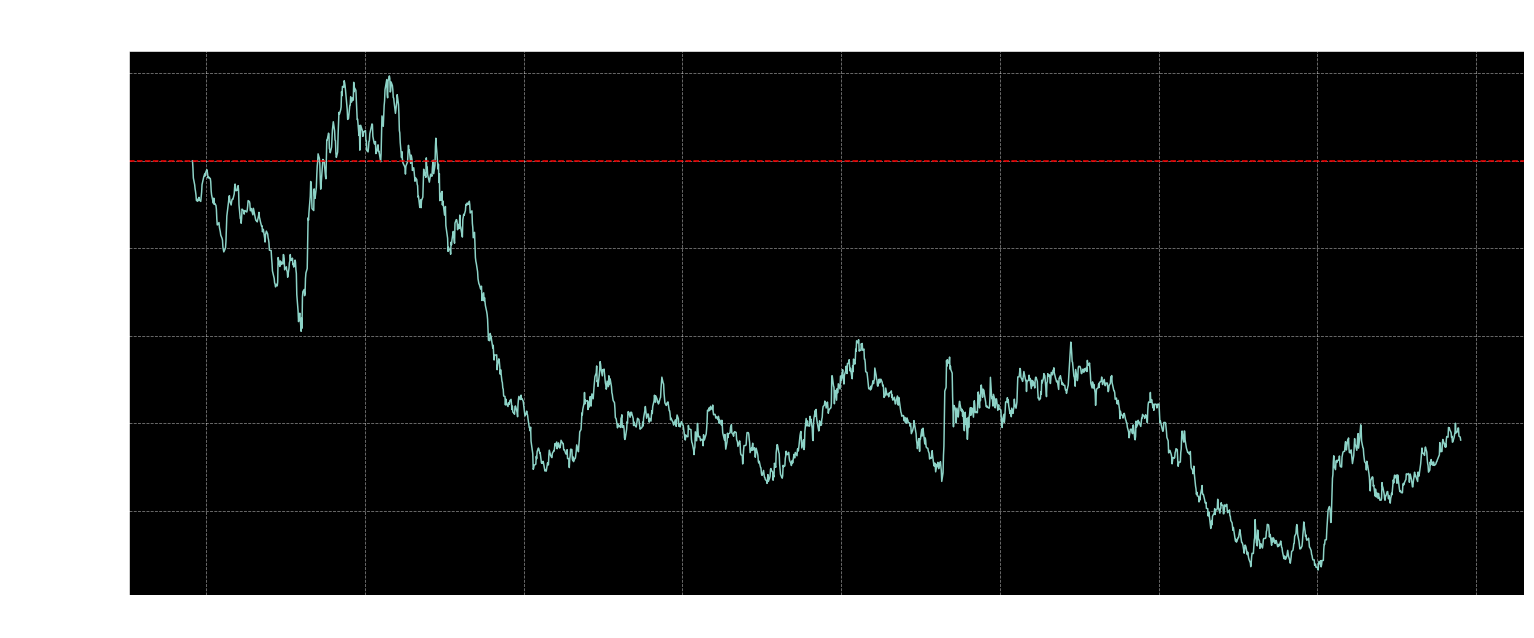

In [39]:
df = differential_strategy(0.11)
df['Total'] = df[ticker[0]] + df[ticker[1]]
plt.figure(figsize=(25,10))
plt.plot(df['Total'])
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)
plt.title('Asset Value',fontsize=50)
plt.grid(linestyle='--',alpha=0.5)
plt.gca()
plt.axhline(y=200000, color='r', linestyle='--')

In [40]:
for dif in np.arange(0.1, 0.35, 0.01):
    df = differential_strategy(dif)
    value = df.iloc[-1][ticker[0]] + df.iloc[-1][ticker[1]]
    if value > criterion:
        print('Differential Value : %f%%\n' % (100*dif))
        print(df)
        print('-------------------------------------------------------------------------')

## <center>CB Tree Balancing Strategy

In [41]:
capital = 200000
criterion = 200000
basis_point = dfs['VIX_Futures']['Cont2/1']
spread = 0
fee = 0
 
signals = {'buy_upper': 0.08, 'buy_lower': -0.08, 'sell_upper': 0.06, 'sell_lower': -0.06}

trading_days = len(dfs['SPX Index'])
cont_tickers = ['ZIV US Equity', 'SH US Equity']
back_tickers = ['VXZ US Equity', 'SPY US Equity']
proportion = 0.35

In [42]:
def CBT_strategy(trading_days=trading_days, basis=basis_point, signals=signals, 
                 cont_tickers=cont_tickers, back_tickers=back_tickers, port=proportion, capital=capital):
    
    port_value = pd.DataFrame( np.zeros((trading_days, 4)), columns = cont_tickers + back_tickers )
    cash_value = pd.DataFrame( np.zeros(trading_days), columns=['Cash Position'] )
    pos = 0  # {-1: back, 0: nothing, 1:cont}
    
    for i in range(trading_days):
        
        if i != 0: 
            port_value[cont_tickers[0]][i] = port_value[cont_tickers[0]][i-1] * (1 + dfs[cont_tickers[0]]['Return'][i])
            port_value[cont_tickers[1]][i] = port_value[cont_tickers[1]][i-1] * (1 + dfs[cont_tickers[1]]['Return'][i])
            port_value[back_tickers[0]][i] = port_value[back_tickers[0]][i-1] * (1 + dfs[back_tickers[0]]['Return'][i])
            port_value[back_tickers[1]][i] = port_value[back_tickers[1]][i-1] * (1 + dfs[back_tickers[1]]['Return'][i])
            cash_value.iloc[i] = cash_value.iloc[i-1]
        else:
            cash_value.iloc[0] = capital
        
 ############################################################       
        if basis.iloc[i] >= signals['buy_upper']: # Long Inverse VIX Futures , Short S&P500
            ## Check if position = 0 , long contango assets 
            if pos == 0: 
                port_value[cont_tickers[0]][i] = cash_value.iloc[i] * port  # VIX
                port_value[cont_tickers[1]][i] = cash_value.iloc[i] * (1 - port)  # Inverse_VIX
                cash_value.iloc[i] = 0
                pos = 1
            ## Check if position = -1 , Close the backwardation position  
            elif pos == -1:
                cash_value.iloc[i] = port_value[back_tickers[0]][i].copy() + port_value[back_tickers[1]][i].copy()
                port_value[back_tickers[0]][i] = 0
                port_value[back_tickers[1]][i] = 0
                # then , long contango assets 
                port_value[cont_tickers[0]][i] = cash_value.iloc[i] * port  # VIX
                port_value[cont_tickers[1]][i] = cash_value.iloc[i] * (1 - port)  # Inverse_VIX
                cash_value.iloc[i] = 0
                pos = 1  # change position signal to 1
            ## Check if position = 1 , continue to hold the contango assets
            else:
                pass
        
        elif basis.iloc[i] <= signals['buy_lower']: # Long VIX Futures , Long S&P500
            ## Check if position = 0 , long backwardation assets 
            if pos == 0:
                port_value[back_tickers[0]][i] = cash_value.iloc[i] * port
                port_value[back_tickers[1]][i] = cash_value.iloc[i] * (1 - port)
                cash_value.iloc[i] = 0
                pos = -1
            ## Check if position = -1 , Close the contango position     
            elif pos == 1:
                cash_value.iloc[i] = port_value[cont_tickers[0]][i].copy() + port_value[cont_tickers[1]][i].copy()
                port_value[cont_tickers[0]][i] = 0
                port_value[cont_tickers[1]][i] = 0
                # then , long backwardation assets 
                port_value[back_tickers[0]][i] = cash_value.iloc[i] * port  # VIX
                port_value[back_tickers[1]][i] = cash_value.iloc[i] * (1 - port)  # Inverse_VIX
                cash_value.iloc[i] = 0
                pos = -1  # change position signal to -1
            ## Check if position = -1 , continue to hold the backwardation assets
            else:
                pass
                
        elif basis.iloc[i] <= signals['sell_upper'] and basis.iloc[i] >= signals['sell_lower']: # Close the Position
            if pos == 1:
                # sell 1
                cash_value.iloc[i] = port_value[cont_tickers[0]][i].copy() + port_value[cont_tickers[1]][i].copy()
                port_value[cont_tickers[0]][i] = 0
                port_value[cont_tickers[1]][i] = 0
                pos = 0
            elif pos == -1:
                # sell -1
                cash_value.iloc[i] = port_value[back_tickers[0]][i].copy() + port_value[back_tickers[1]][i].copy()
                port_value[back_tickers[0]][i] = 0
                port_value[back_tickers[1]][i] = 0
                pos = 0
            else:
                pass
            
    close_total_value = port_value.iloc[-1].sum() + cash_value.iloc[-1].sum()     
    return port_value[:], cash_value[:] , close_total_value

#### A simple test for the CB_Tree function

In [43]:
a,b,c = CBT_strategy()
print(c)

362184.8606272704


## <center>For Loop Setup

In [44]:
bu = np.arange(0.04, 0.1, 0.01)
su = np.arange(0.03, 0.09, 0.01)
sl = np.arange(-0.03, -0.09, -0.01)
bl = np.arange(-0.04, -0.1, -0.01)

#### Calculate loop counts for dataframe creation
counts = 0
for x in itertools.product( bu, su, sl, bl ):
    if x[0]>x[1] and x[2]>x[3]:
        counts += 1

CB_cash_results = pd.DataFrame( np.zeros((counts,5)), columns=['Buy_Upper','Sell_Upper','Sell_Lower','Buy_Lower','Total Value'] )

In [45]:
max_batchs = counts
progress_bar = ProgressBar(counts)
loop = 0

for x in itertools.product( bu, su, sl, bl ):
    
    if x[0]>x[1] and x[2]>x[3]:         
        signals['buy_upper'] = x[0]
        signals['sell_upper'] = x[1]
        signals['sell_lower'] = x[2]
        signals['buy_lower'] = x[3]
        port_v, cash_v , close_total =  CBT_strategy()
               
        CB_cash_results['Buy_Upper'][loop] = signals['buy_upper']
        CB_cash_results['Sell_Upper'][loop] = signals['sell_upper']
        CB_cash_results['Sell_Lower'][loop] = signals['sell_lower']
        CB_cash_results['Buy_Lower'][loop] = signals['buy_lower']
        CB_cash_results['Total Value'][loop] = close_total
        
        progress_bar.update(loop)
        loop += 1

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


In [53]:
CB_cash_results.sort_values('Total Value',ascending=False).head(10)
# CB_cash_results[CB_cash_results['Total Value'].isin(list(sorted(CB_cash_results['Total Value'])[-20:]))]

,Buy_Upper,Sell_Upper,Sell_Lower,Buy_Lower,Total Value
189,0.07,0.06,-0.03,-0.04,404272.586778
273,0.08,0.06,-0.03,-0.04,403671.242435
294,0.08,0.07,-0.03,-0.04,401770.803290
399,0.09,0.07,-0.03,-0.04,400255.434356
420,0.09,0.08,-0.03,-0.04,398841.430157
195,0.07,0.06,-0.04,-0.05,396866.363831
105,0.06,0.05,-0.03,-0.04,396468.080459
190,0.07,0.06,-0.03,-0.05,394934.578241
378,0.09,0.06,-0.03,-0.04,393066.385385
279,0.08,0.06,-0.04,-0.05,392956.466545
